In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

In [2]:

img_file = "input/ang20180812t232708rfl/ang20180812t232708_rfl_v2r2_img"
hdr_file = "input/ang20180812t232708rfl/ang20180812t232708_rfl_v2r2_img.hdr"
print(img_file)
print(hdr_file)

input/ang20180812t232708rfl/ang20180812t232708_rfl_v2r2_img
input/ang20180812t232708rfl/ang20180812t232708_rfl_v2r2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(img_file)

# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	659
Rows (y-axis):	9426


In [4]:
# Read header file and get the metadata
def read_envi_header(file_path):
    metadata = {}
    with open(file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if " = " in line:
                key, value = line.strip().split(" = ", 1)
                metadata[key.strip()] = value.strip().strip('{}')
            elif line.strip().endswith('}'):
                # Multi-line metadata
                key, value = lines[lines.index(line) - 1].strip().split(" = ", 1)
                metadata[key.strip()] += line.strip().strip('{}')
    return metadata

metadata = read_envi_header(hdr_file)

In [5]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img_open.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img_open.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands.head(10)

,Band number,Band center (nm),EM region
1,1,376.86,visible-violet
2,2,381.87,visible-violet
3,3,386.88,visible-violet
4,4,391.89,visible-violet
5,5,396.89,visible-violet
6,6,401.90,visible-violet
7,7,406.91,visible-violet
8,8,411.92,visible-violet
9,9,416.93,visible-violet
10,10,421.94,visible-violet


In [6]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img_open.GetRasterBand(int(b["Band number"])).ReadAsArray()

# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# set fill values (-9999.) to 0 for each array
Ra[Ra == -9999.], Ga[Ga == -9999.], Ba[Ba == -9999.] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# set rescaled fill pixels back to 0 for each array
Ra8[Ra == 0], Ga8[Ga == 0], Ba8[Ba == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = Ra8, Ga8, Ba8

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                  59
Band center (nm)         667.36
EM region           visible-red
Name: 59, dtype: object
------------------------------------------------------------
Band number                    34
Band center (nm)           542.15
EM region           visible-green
Name: 34, dtype: object
------------------------------------------------------------
Band number                   20
Band center (nm)          472.02
EM region           visible-blue
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (9426, 659, 3)


In [7]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img_open.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

print("the first 10 x coordinates:")
xarr[:10]

the first 10 x coordinates:


array([418543, 418545, 418548, 418550, 418552, 418555, 418557, 418559,
       418562, 418564])

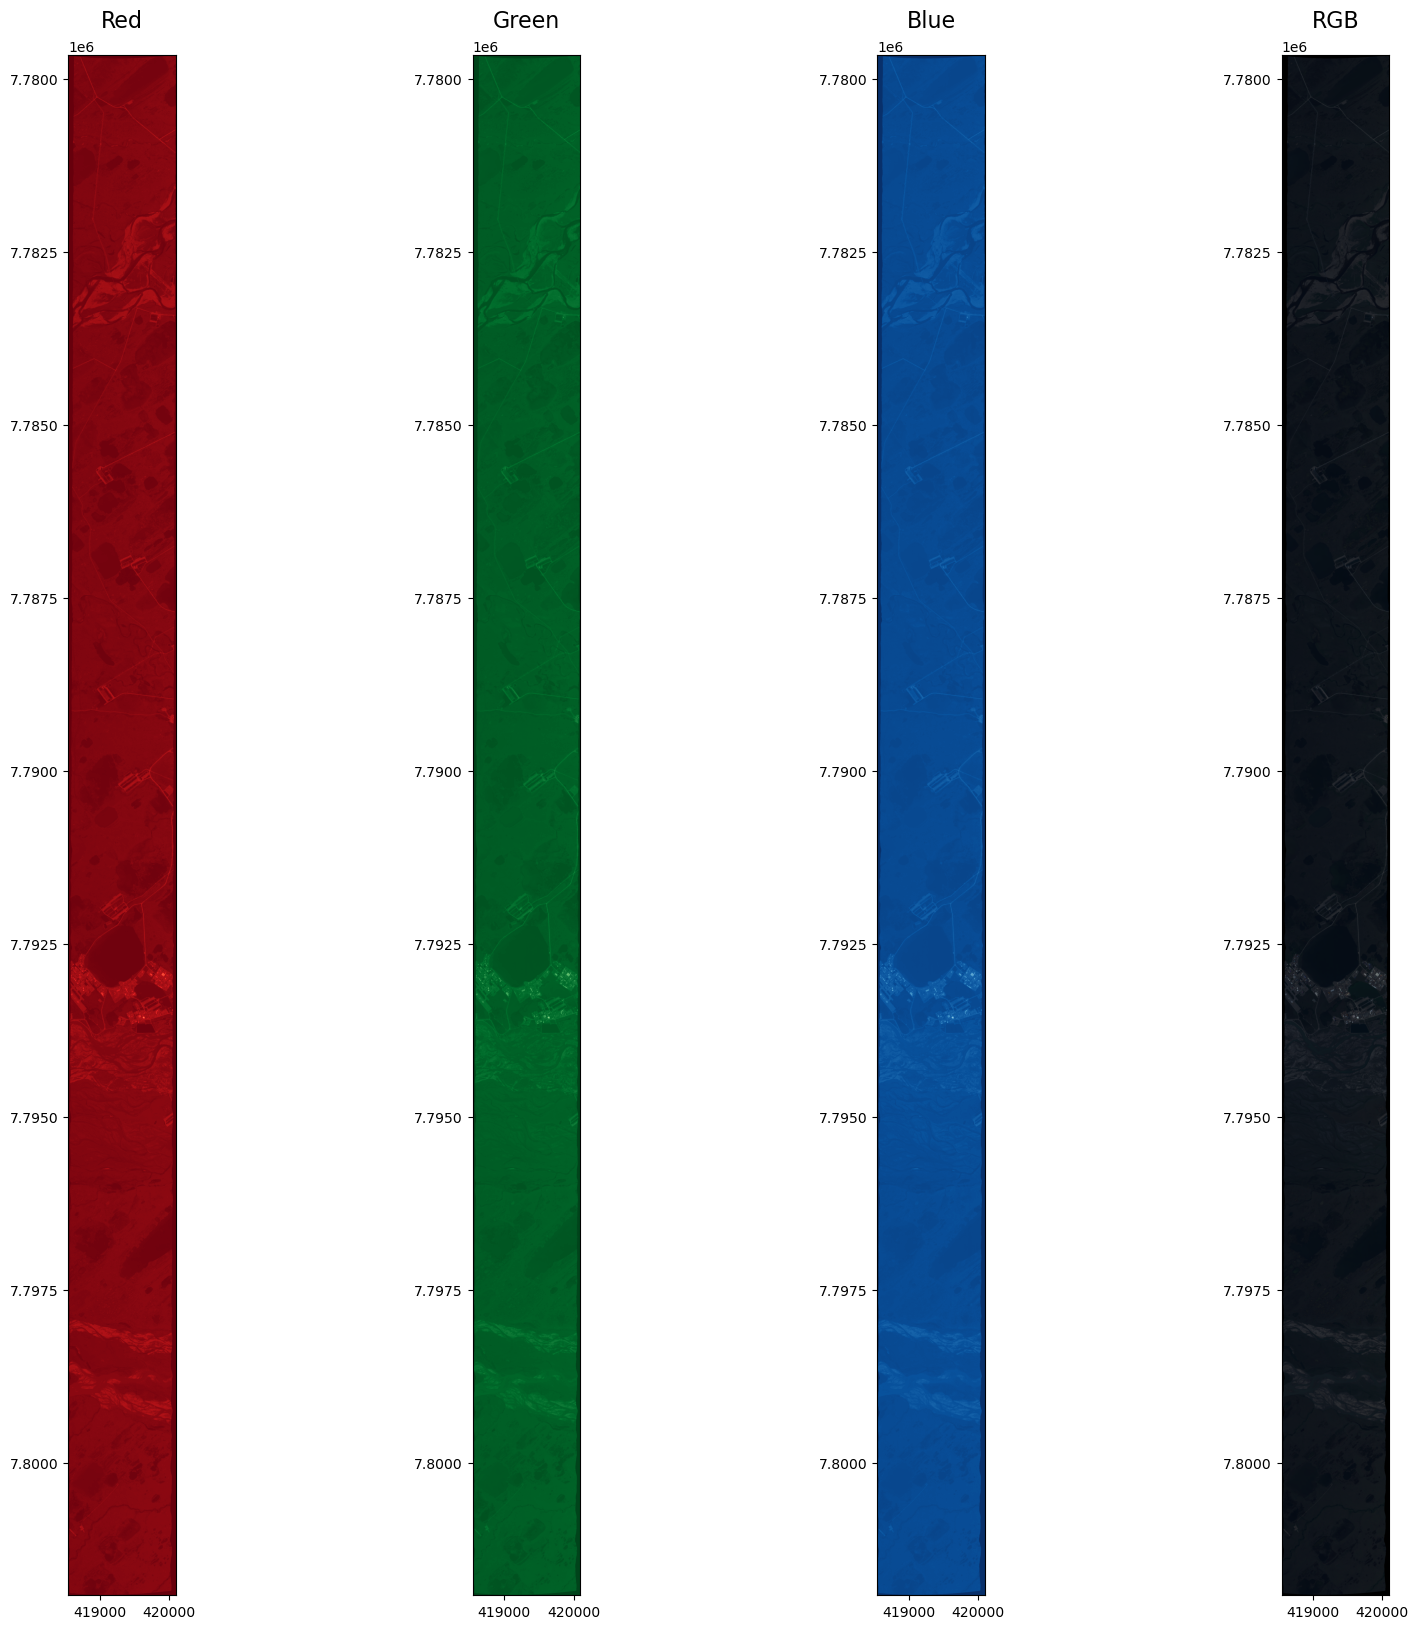

In [8]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)  
    
plt.imshow(rgb_stack, extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])

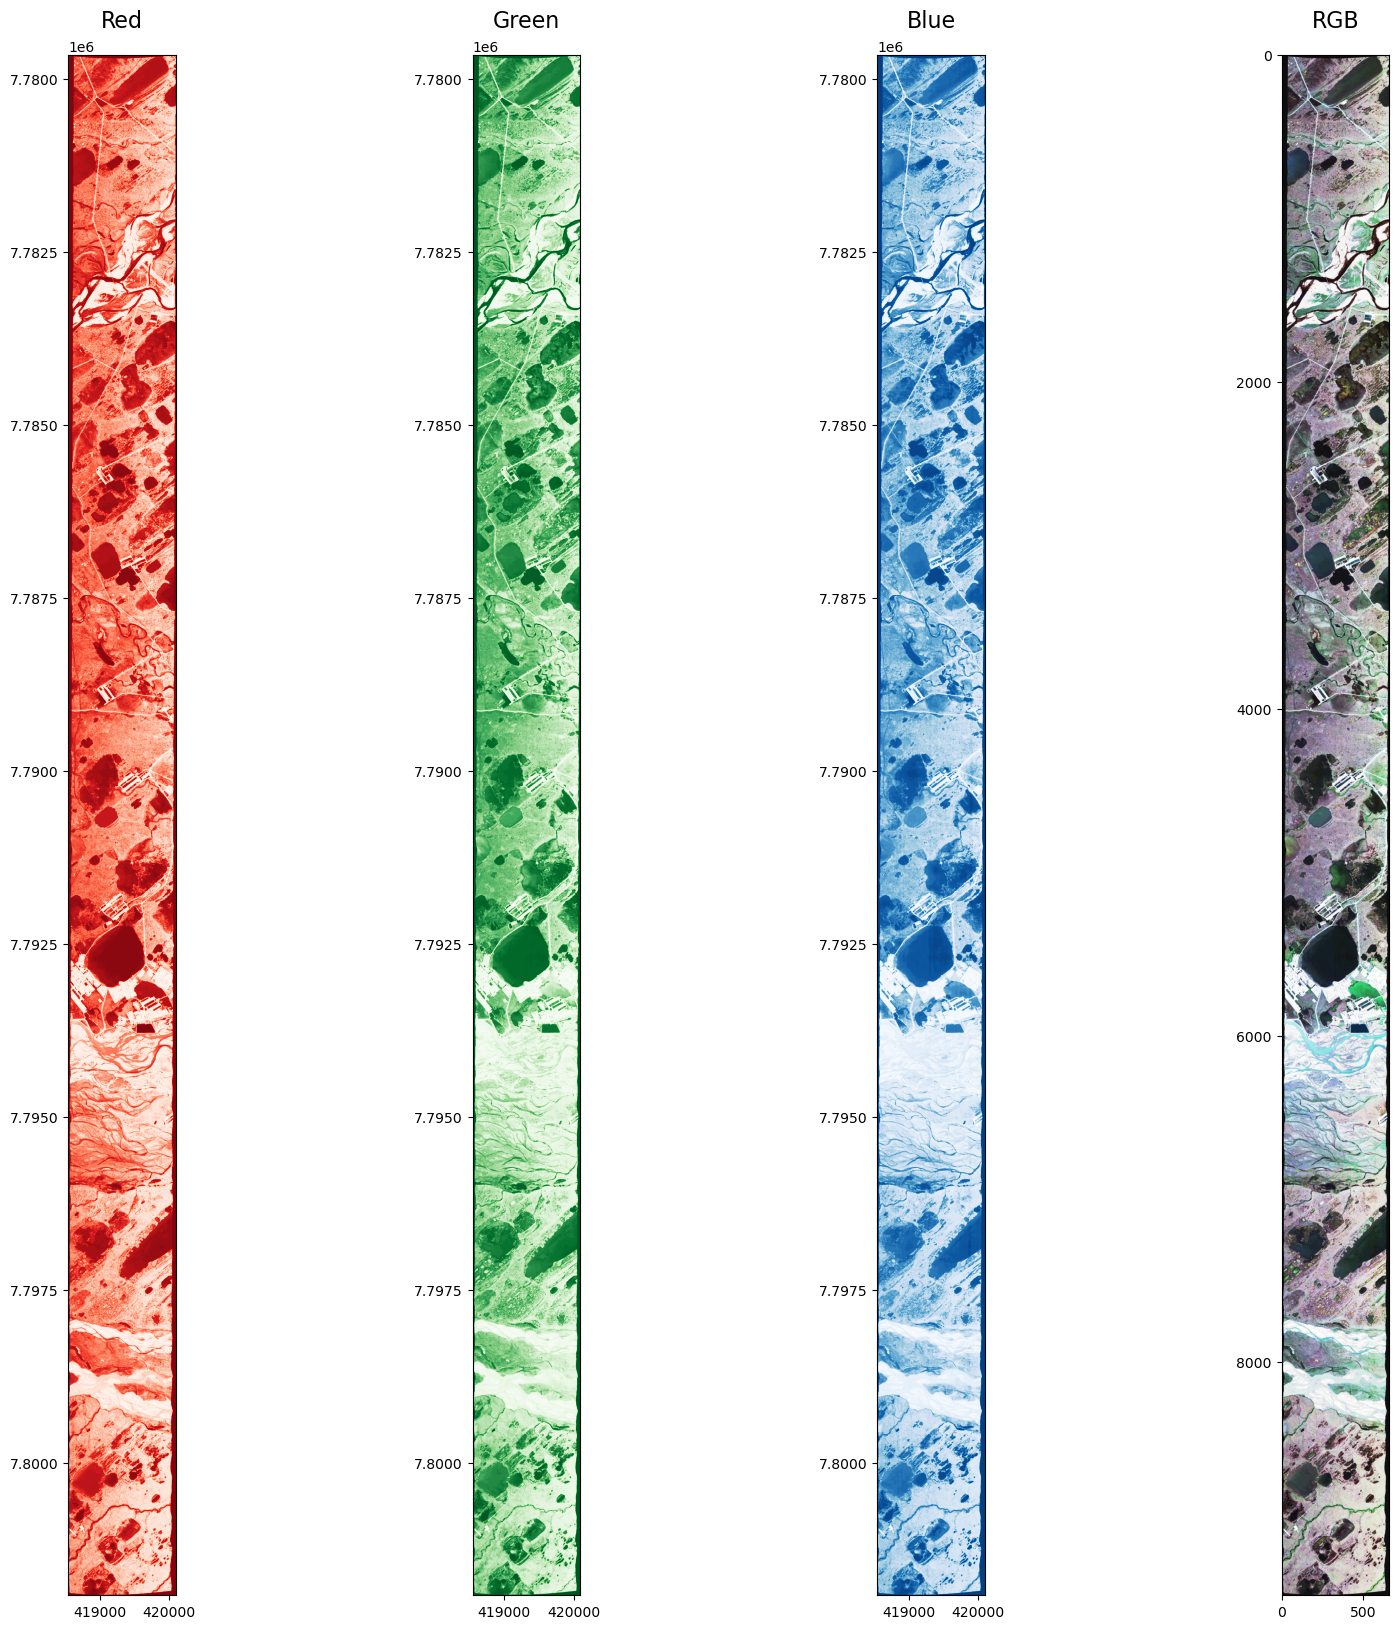

In [9]:
# apply histogram equalization to each band
for i in range(rgb_stack.shape[2]):

    # band i
    b = rgb_stack[:,:,i]
    
    # histogram from flattened (1d) image
    b_histogram, bins = np.histogram(b.flatten(), 256)

    # cumulative distribution function
    b_cumdistfunc = b_histogram.cumsum()

    # normalize
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]

    # get new values by linear interpolation of cdf
    b_equalized = np.interp(b.flatten(), bins[:-1], b_cumdistfunc)
    
    # reshape to 2d and add back to rgb_stack
    rgb_stack[:,:,i] = b_equalized.reshape(b.shape)
    
    
# plot. all of this is matplotlib ---------->
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': rgb_stack[:,:,0], 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': rgb_stack[:,:,1], 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': rgb_stack[:,:,2], 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

# initialize plot and add ax element for each array in plotdict
fig1 = plt.figure()
for band,data in plotdict.items():
    clim = None if band == "RGB" else (0,255)
    ax = fig1.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=data['colormap'], clim=clim,
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)
plt.imshow(rgb_stack)